In [1]:
import sys
sys.path.append('..')
import er_est as er
import matplotlib.pyplot as plt
import numpy as np


## Neuron-to-model (n2m) correlation estimators
Below I demonstrate the use of functions employed in 'The unbiased estimation of the fraction of variance explained by a model' Pospisil and Bair, 2020 https://www.biorxiv.org/content/10.1101/2020.10.30.361253v1 on data simulated in the same manner as the simulations in the paper. Please see paper and code comments for further detail.

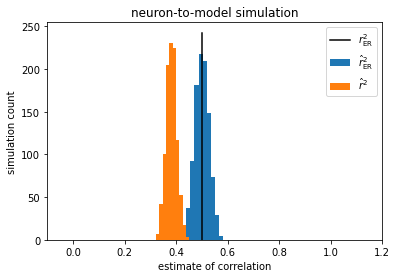

In [2]:
# %% test simulation of r2er n2m,
r2er, sig2, d2y, n, m, n_exps = 0.5, 0.25, 100, 4, 500, 1000
x, y = er.sim_n2m(r2er, sig2, d2y, n, m, n_exps, verbose=True)#generate model (x) and data (y)
hat_r2er, hat_r2 = er.r2er_n2m(x, y)#corrected and naive estimate of r2

plt.figure()
plt.hist(hat_r2er.squeeze())
plt.hist(hat_r2.squeeze())
plt.xlim(-0.1, 1.2)
lly, uly = plt.gca().get_ylim()
plt.plot([r2er, r2er], [lly, uly], c='k')
plt.legend([r'$r^2_{\rm ER}$', r'$\hat{r}^2_{\rm ER}$', r'$\hat{r}^2$'])
plt.xlabel('estimate of correlation')
plt.ylabel('simulation count')
plt.title(r'neuron-to-model simulation');

In [3]:
# %% run ecci confidence interval method n2m, it is slow
res = er.ecci_r2er_n2m(x, y[0],
                       alpha_targ=0.1,#desired alpha of confidence interval
                       n_r2er_sims=1000,
                       p_thresh=0.05,
                       n_splits=20, trace=None)

ll, ul, r2er_hat_obs, trace, ll_alpha, ul_alpha = res
print('n2m ci')
print('lower  est upper')
print(np.round(ll, 2), np.round(r2er_hat_obs.squeeze(), 2), np.round(ul, 2))

n2m ci
lower  est upper
0.43 0.47 0.52


In [18]:
# %% run alternative ci methods for n2m
r2er, sig2, d2y, n, m, n_exps = 0.5, 0.5, 1, 1000, 4, 1000
x, y = er.sim_n2m(r2er, sig2, d2y, n, m, n_exps, verbose=True)
r2_er_obs = er.r2er_n2m(x, y)[0]
y = y[0]
alpha_targ = 0.01
ci_npbs_ci = er.get_npbs_ci(x, y, alpha_targ, n_bs_samples=1000)
ci_pbs = er.get_pbs_ci(x, y, alpha_targ, n_pbs_samples=1000)
ci_pbs_bca = er.get_pbs_bca_ci(x, y, alpha_targ, n_bs_samples=1000)

print('r2er estimate')
print(np.round(r2_er_obs.squeeze()[0], 3))
print('non-parametric bootstrap ci n2m')
print(np.round(ci_npbs_ci, 3))
print('parametric bootstrap ci n2m')
print(np.round(ci_pbs, 3))
print('parametric bootstrap corrected and accelerated (CA) ci n2m')
print(np.round(ci_pbs_bca,2))

r2er estimate
0.484
non-parametric bootstrap ci n2m
[0.43  0.541]
parametric bootstrap ci n2m
[0.427 0.54 ]
parametric bootstrap ca ci n2m
[0.43 0.54]


Text(0.5, 1.0, 'neuron-to-model alternative estimates')

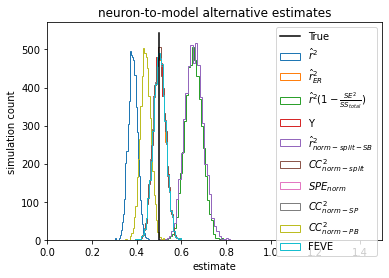

In [4]:
# %% run simulation of alternative n2m estimators
r2er, sig2, d2y, n, m, n_exps = 0.5, 0.25, 100, 4, 500, 5000
x, y = er.sim_n2m(r2er, sig2, d2y, n, m, n_exps, verbose=True)
res = []
for i in range(n_exps):
    a_y = y[i]
    mod = np.zeros((len(x), 2))
    mod[:, 0] = 1
    mod[:, 1] = x.squeeze()
    beta = np.linalg.lstsq(mod, a_y.mean(0), rcond=-1)[0]
    y_hat = np.dot(beta[np.newaxis], mod.T).squeeze()

    hat_r2er, hat_r2 = er.r2er_n2m(x.T, a_y)
    r2_pc = er.r2_SE_corrected(x.squeeze(), a_y)
    r2_upsilon = er.upsilon(y_hat, a_y)
    r2_hsu = er.cc_norm_split(x.squeeze(), a_y)**2
    r2_yd = er.r2_SB_normed(x.squeeze(), a_y)
    r2_sl = er.normalized_spe(y_hat, a_y)
    r2_sc = er.cc_norm(x.squeeze(), a_y)**2
    r2_zyl = er.cc_norm_bs(x.squeeze(), a_y)**2
    r2_cad = er.feve_cadena(y_hat, a_y)

    res.append([np.double(hat_r2),
                np.double(hat_r2er),
                r2_pc,
                r2_upsilon,
                r2_yd,
                r2_hsu,
                r2_sl,
                r2_sc,
                r2_zyl,
                r2_cad])

res = np.array(res)

plt.figure()
for i in range(10):
    plt.hist(res[:, i], histtype='step', bins=30)

leg = ['True',
       r'$\hat{r}^2$',
       r'$ \hat{r}^2_{ER}$',
       r'$ \hat{r}^2  (1-\frac{SE^2}{SS_{total}})$',
       r'$ \Upsilon $',
       r'$\hat{r}^2_{norm-split-SB}$',
       r'$CC^2_{norm-split}$',
       r'$SPE_{norm}$',
       r'$CC^2_{norm-SP}$',
       r'$CC^2_{norm-PB}$',
       'FEVE',
       'Truth']

plt.xlim(0, 1.5)
lly, uly = plt.gca().get_ylim()
plt.plot([r2er, r2er], [lly, uly], c='k')
plt.legend(leg)
plt.xlabel('estimate')
plt.ylabel('simulation count')
plt.title('neuron-to-model alternative estimates')